## 📘 Notebook Goal

This tutorial demonstrates how to compute and interpret irreducible lower bounds on loss functions during gradient descent training. These bounds reveal the limits of convergence regardless of optimizer tuning, dataset size, or architecture complexity. The notebook walks through a hands-on implementation using a toy dataset and a simple model, highlighting the theoretical insights with practical computations.

By the end of this notebook, you'll be able to:
- Understand how sample-wise gradient norms affect convergence.
- Estimate lower bounds on achievable loss.
- Evaluate the speed and limitations of training dynamics.

In [ ]:
#!pip install torchinfo
#!pip install compress-json

In [2]:
import os
import random
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
import torchvision.transforms.functional as T

from torchinfo import summary

In [3]:
def set_random_seed(seed:int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed(42)

# 1. Load Dataset

Here, we load a simple dataset (e.g., synthetic regression/classification, MNIST, CIFAR100, etc...)

In [12]:
trainset = datasets.CIFAR10(
    root ="dataset_cifar10",
    train = True,
    transform = transforms.ToTensor(),
    download = True
)

100%|██████████| 170M/170M [00:03<00:00, 51.9MB/s] 


In [13]:
len(trainset)

50000

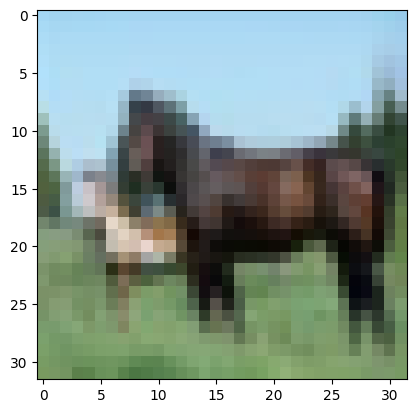

In [14]:
image, label = trainset[12]

pil_image = T.to_pil_image(image)
plt.imshow(pil_image)

## 2. Define Model Architecture

We define a minimal model, such as a linear regressor or small MLP. The simplicity of the architecture allows us to

In [16]:
import torchvision.models as models


class ResNet18(nn.Module):
  def __init__(self, num_classes=100):
    super().__init__()
    self.backbone = models.resnet18(weights=models.ResNet18_Weights)
    self.backbone.fc = nn.Linear(512, num_classes)

  def forward(self,x):
    return self.backbone(x)


class ResNet34(nn.Module):
  def __init__(self, num_classes=100):
    super().__init__()
    self.backbone = models.resnet34(weights=models.ResNet34_Weights)
    self.backbone.fc = nn.Linear(512, num_classes)

  def forward(self,x):
    return self.backbone(x)



class ViTB16(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.backbone = models.vit_b_16(weights='DEFAULT')
        self.backbone.heads = nn.Sequential(
            nn.Linear(self.backbone.hidden_dim, num_classes)
        )
    def forward(self, x):
        # Resize input to 224x224 (ViT's expected input size)
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return self.backbone(x)


class ViTB32(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.backbone = models.vit_b_32(weights='DEFAULT')
        self.backbone.heads = nn.Sequential(
            nn.Linear(self.backbone.hidden_dim, num_classes)
        )
    def forward(self, x):
        # Resize input to 224x224 (ViT's expected input size)
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return self.backbone(x)


class ViTL16(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.backbone = models.vit_l_16(weights='DEFAULT')
        self.backbone.heads = nn.Sequential(
            nn.Linear(self.backbone.hidden_dim, num_classes)
        )
    def forward(self, x):
        # Resize input to 224x224 (ViT's expected input size)
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return self.backbone(x)



model = ResNet34()
dummy_data = torch.rand(7, 3, 32, 32)
summary(model, input_data=dummy_data)

Layer (type:depth-idx)                        Output Shape              Param #
ResNet34                                      [7, 100]                  --
├─ResNet: 1-1                                 [7, 100]                  --
│    └─Conv2d: 2-1                            [7, 64, 16, 16]           9,408
│    └─BatchNorm2d: 2-2                       [7, 64, 16, 16]           128
│    └─ReLU: 2-3                              [7, 64, 16, 16]           --
│    └─MaxPool2d: 2-4                         [7, 64, 8, 8]             --
│    └─Sequential: 2-5                        [7, 64, 8, 8]             --
│    │    └─BasicBlock: 3-1                   [7, 64, 8, 8]             73,984
│    │    └─BasicBlock: 3-2                   [7, 64, 8, 8]             73,984
│    │    └─BasicBlock: 3-3                   [7, 64, 8, 8]             73,984
│    └─Sequential: 2-6                        [7, 128, 4, 4]            --
│    │    └─BasicBlock: 3-4                   [7, 128, 4, 4]            230,144

In [17]:
architectures = {
    "ResNet18": ResNet18,
    "ResNet34": ResNet34,
    "ViTB16": ViTB16,
    "ViTB32": ViTB32,
}


# 3. Training

In [18]:
from dataclasses import dataclass, asdict


@dataclass
class TrainArgs:
    log_interval: int = 5
    num_epoch: int = 1
    device = "cuda"
    batch_size :int = 32
    num_workers : int = 8
    learning_rate : int = 1e-3
    weight_decay : int = 0



def compute_convergence_rate(model: nn.Module, batch: torch.Tensor) -> torch.Tensor:
    """ Compute the convergence pseudo-root-velocity K = SQRT(1/n * sum_{i=1}^n ||grad_w f(x_i, w)||^2)
        Args:
            model: Neural network model
            batch: Input batch of data of size n
        Returns:
            K value as described above
        Handles:
            - Classification (multi-class or multi-label): ||grad_w f(x_i, w)||^2 is the norm over all class gradients
            - Regression (single or multiple outputs): ||grad_w f(x_i, w)||^2 is the sum over all output dimensions
    """
    logits = model(batch)
    batch_size = batch.size(0)
    grad_norms = []

    for i in range(batch_size):
        # Compute the norm of the gradient of the output w.r.t the parameters:
        # ||grad_w f(x_i, w)||^2 = sum_{j=1}^n_outputs ||grad_w f(x_i, w)_{j}||^2
        grad_sq_norm = 0.0
        sample_logits = logits[i]

        for j in range(sample_logits.numel()):
            # Accumulate squared norm of the gradient of the j-th output with respect to parameters
            output = sample_logits.reshape(-1)[j]
            grads = torch.autograd.grad(output, model.parameters(), retain_graph=True, create_graph=False)
            grad_sq_norm += sum(g.pow(2).sum() for g in grads)
        grad_norms.append(grad_sq_norm)

    # Average over the batch and take square root
    return torch.stack(grad_norms).mean().sqrt()




def train(model: nn.Module, train_loader: DataLoader, optimizer, scheduler, args: TrainArgs) -> tuple[np.ndarray]:
    """ Train the model for one epoch on the given data loader.

        Args:
            model: Neural network to train
            train_loader: DataLoader providing training batches
            optimizer: Optimizer used for parameter updates
            args: Training arguments (device, epoch, log_interval, etc.)

        Returns:
            loss_history: Array of loss values at each batch
            convergence_rate_history: Array of K values (pseudo-root-velocity) at logging steps
    """
    device = args.device
    model = model.to(device).train()
    n_batches = len(train_loader)

    loss_history = []
    cvr_history = []
    time_steps = []
    time_step = 0

    for epoch in range(args.num_epoch):
        progress_bar = tqdm(enumerate(train_loader), ncols=100, total=n_batches, disable=False)
        for batch_idx, (data, target) in progress_bar:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            logits = model(data)
            loss = F.cross_entropy(logits, target)

            loss.backward()
            optimizer.step()
            lr = scheduler.get_last_lr()[0]

            if batch_idx % args.log_interval == 0:
                cvr = compute_convergence_rate(model, data).cpu()
                cvr_history.append(cvr.item())
                loss_history.append(loss.item())
                time_steps.append(time_step)

                message = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    args.num_epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item())
                progress_bar.set_description(message)

            time_step += lr
            if batch_idx == 100:
                break

        scheduler.step()
    return cvr_history, loss_history, time_steps

# 4. Run Numerical Experiment

In [ ]:
NUM_CLASSES = 100
train_args = TrainArgs(batch_size=32, num_workers=2, learning_rate=1e-4)


train_loader = DataLoader(
    trainset,
    batch_size=train_args.batch_size,
    num_workers=train_args.num_workers,
    pin_memory=True,
    shuffle=False
)


optimizers:dict[str, torch.optim.Optimizer] = {
    "SGD" : torch.optim.SGD,
    #"Adam": torch.optim.Adam,
    "AdamW": torch.optim.AdamW,
    "RMSProp": torch.optim.RMSprop
}


results = {}

for arch_name, architecture  in architectures.items():
  model = architecture(NUM_CLASSES)
  results[arch_name] = {}
  initial_model_state_dict = deepcopy(model.state_dict())

  for opt_name, optimizer in optimizers.items():
    print(arch_name, opt_name)

    model.load_state_dict(initial_model_state_dict)
    optimizer = optimizer(model.parameters(), lr=train_args.learning_rate, weight_decay=train_args.weight_decay)
    scheduler = StepLR(optimizer, step_size=4, gamma=1)
    
    cvr, losses, time_steps = train(model=model, train_loader=train_loader, optimizer=optimizer, scheduler=scheduler, args=train_args)
    results[arch_name][opt_name] = {"cvr":cvr, "loss":losses, "time_steps":time_steps}


# 2 - Analysis

In [ ]:
from scipy.interpolate import make_interp_spline
from scipy.interpolate import CubicSpline
from scipy.integrate import odeint
from typing import Union



class IrreducibleFloor:
    def __init__(self, initial_loss:float, time_steps:Union[float, np.ndarray], conv_rate:Union[float, np.ndarray]):
        """
            initial_loss : initial value of the training loss across batche or the entire dataset
            learning_rate: sequence of learning rate (this can be a constant value if the learning rate is fixed)
            rate: sequence of convergence rates
        """
        self.initial_loss = initial_loss
        self.time_steps = time_steps
        self.conv_rate = conv_rate
        self.cvr_interp = self.interpolate_conv_rate()

    def interpolate_conv_rate(self):
        """ Create an interpolation between"""
        f_bspline = make_interp_spline(self.time_steps, self.conv_rate, k=3)  # k=3 (cubic), s=0 forces exact fit
        return f_bspline

    def evaluate_cvr_interpolator(self):
        """ Create an interpolation between"""
        return self.cvr_interp(self.time_steps)

    def compute_dynamics(self, x, t):
        """ Compute the exponential lower bound of the loss function """
        pass

    def compute_irreducible_floor(self):
        """ Compute the exponential lower bound of the loss function """
        dx_dt = lambda x, t : self.compute_dynamics(x, t)
        return odeint(dx_dt, self.initial_loss, self.time_steps)



class CategoricalCrossEntropyFloor(IrreducibleFloor):
    def __init__(self, initial_loss:float, time_steps:Union[float, np.ndarray], conv_rate:Union[float, np.ndarray], m:int=2):
        super().__init__(initial_loss=initial_loss, time_steps=time_steps, conv_rate=conv_rate)
        self.scale = 2**(-m + 1)

    def compute_dynamics(self, x, t):
        """ Compute the exponential lower bound of the loss function """
        k = self.cvr_interp(t)
        g = 2 * (1 - np.exp(-x))**2 + self.scale * (x**2) * np.exp(-2 * x)
        return - (k**2) * g


Text(0.5, 0, 'latent time: $t_{k}$')

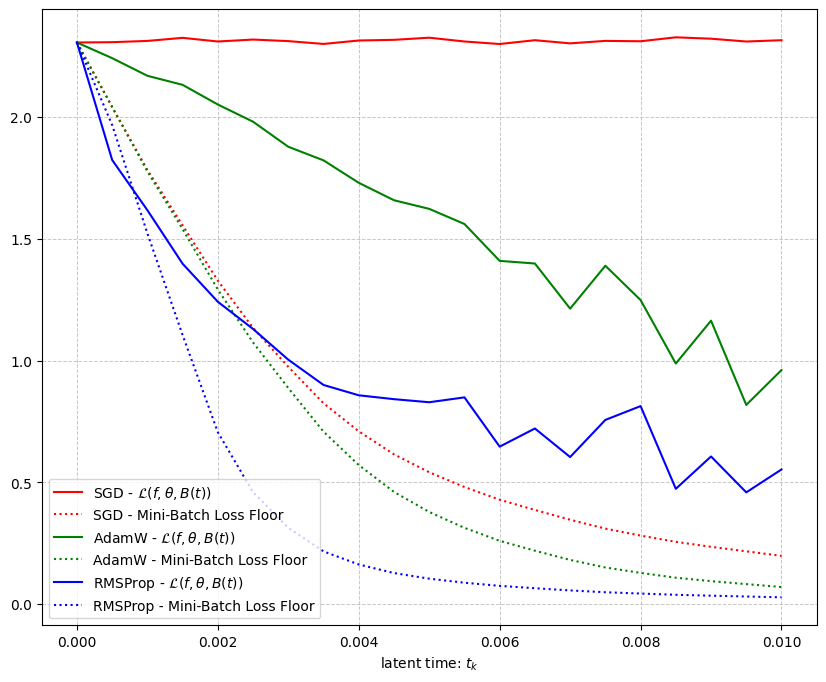

In [ ]:
colors = ["red", "green", "blue", "black"]

fig = plt.figure(figsize=(10, 8))

for idx, (optimizer_name, result) in enumerate(results.items()):
    color = colors[idx]
    #if optimizer_name != "RMSProp": continue
    #print(idx, result["loss"][0])

    cce_floor = CategoricalCrossEntropyFloor(
        initial_loss=result["loss"][0],
        conv_rate=result["cvr"],
        time_steps=result["time_steps"],
        m=2
    )
    time_steps = cce_floor.time_steps
    loss_floor = cce_floor.compute_irreducible_floor()
    plt.plot(time_steps, result["loss"], label=optimizer_name + r" - $\mathcal{L}(f, \theta, B(t))$", color=color)
    plt.plot(time_steps, loss_floor, label=optimizer_name + " - Mini-Batch Loss Floor", color=color, linestyle=":")

plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend()
plt.xlabel(r"latent time: $t_{k}$")
#plt.ylabel(r"Training loss: $\mathcal{L}(t)$")

#plt.loglog()
#plt.xlim(0, 1e-5); plt.ylim(1.7, 2.3)

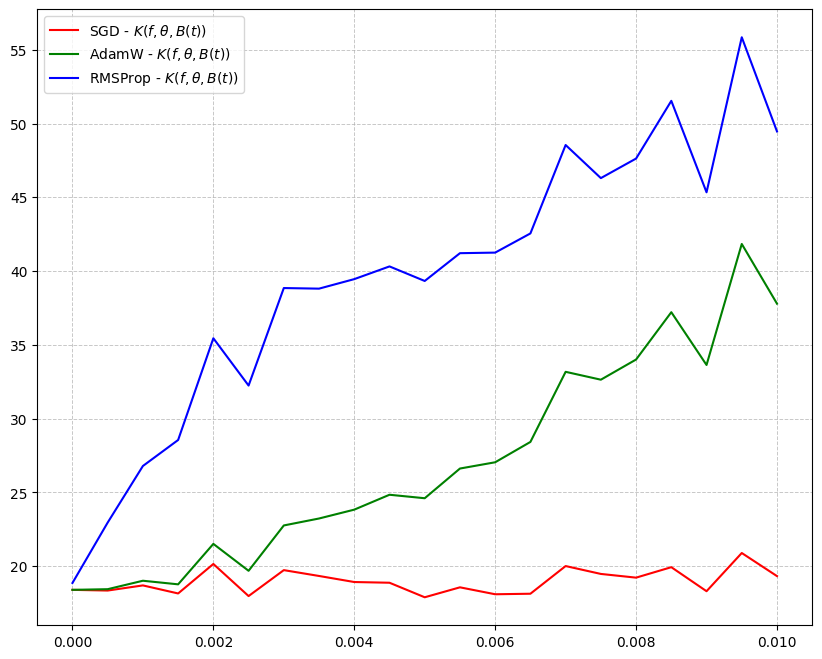

In [ ]:
colors = ["red", "green", "blue", "black"]

fig = plt.figure(figsize=(10, 8))

for idx, (optimizer_name, result) in enumerate(results.items()):
    color = colors[idx]
    plt.plot(result["time_steps"], result["cvr"], label=optimizer_name + r" - $K(f, \theta, B(t))$", color=color)

plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend()
#plt.loglog()
#plt.xlim(0, 1e-5); plt.ylim(1.7, 2.3)